# Transfer Learning

l'objectif icI est d'utiliser un modèle de classification d'images. les signaux 1D 187x1 sont transformés image 2D 224x224x3. 

On utilie une transformation en ondelettes, la cwt : continuous wavelet transform

In [55]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim

In [56]:
from scipy.signal.windows import gaussian
from scipy.ndimage import convolve1d
import joblib

In [110]:
from tqdm.notebook import tqdm
import seaborn as sns

## Conversion to image 224x224

#### Normalisation

sur la base train, on cherche le coefficient de normalisation pour normaliser les images produites. Ce coefficient pourrait probablement est déterminé de façon analytique. mais la on cherche l'amplitude maximale sur toute la base train

In [6]:
X_train, y_train = load_balanced.load('../data/raw/mitbih_train.csv')

In [7]:
from scipy.signal import cwt,ricker,morlet2

In [58]:
checkNorm = False

In [59]:
if checkNorm:
    m=0
    freq = np.linspace(1, 125/2, 224)
    widths = 5*125 / (2*freq*np.pi)
    for k in range(X_train.shape[0]):
        Z = cwt(X_train[k,:],morlet2,widths)
        if np.max(abs(Z))>m:
            print(np.max(abs(Z)))
            m = np.max(abs(Z))
else:
    m = 2.6868181347592515
print(m)


2.6868181347592515


In [60]:
cwtNorm = m
# 2.6868181347592515

le coefficient de normalisation vaut 2.6868181347592515

#### Fonction de transformation

cette fonction s'applique à un tensor.

In [61]:
def sig2cwtimage_tensor(X):

    cwtNorm = 2.6868181347592515
    freq = np.linspace(1, 125/2, 224)
    widths = 5*125 / (2*freq*np.pi)
    c=0
    
    Y = np.zeros((X.shape[0],224,X.shape[1]))
    for k in range(X.shape[0]):
        Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
        
    pad = np.zeros((Y.shape[0],Y.shape[1],37))
    return torch.from_numpy(np.concatenate((Y,pad),axis=-1))

#### examples de transformation 

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


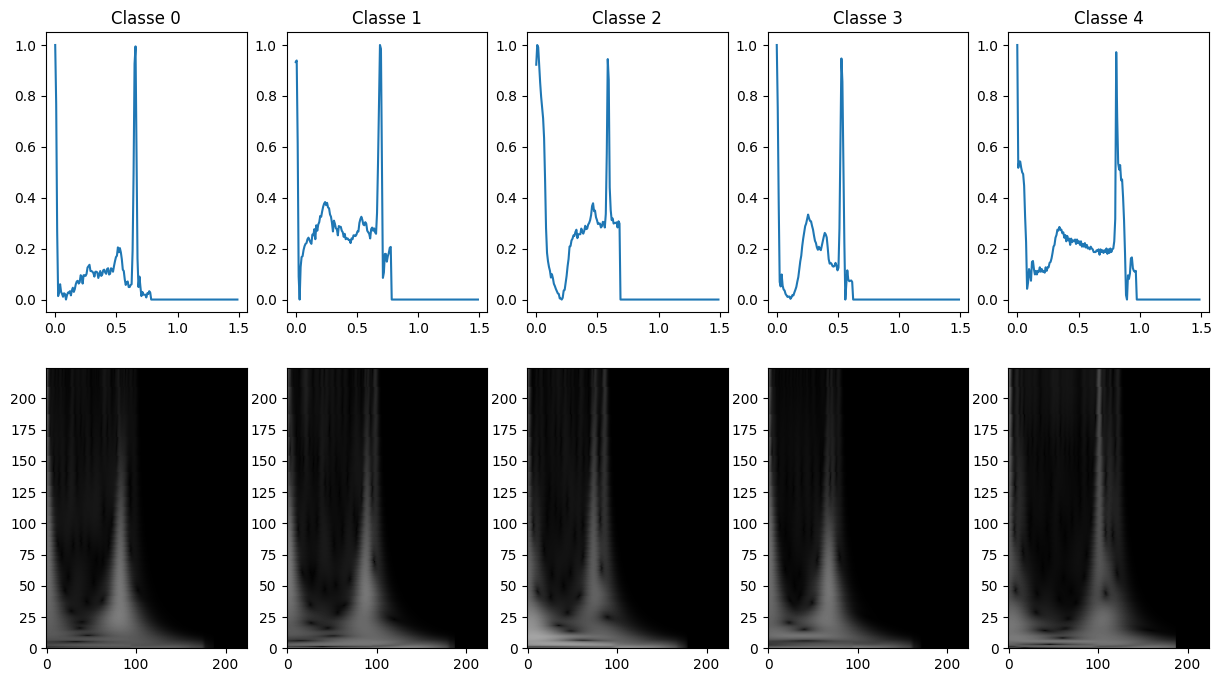

In [39]:
fig, axs = plt.subplots(figsize=(15,8),nrows=2,ncols=5)

for ii in range(5):
    jj = jj = [x for x,y in enumerate(y_train) if y == ii]
    np.random.shuffle(jj)
    jj = jj[0]
    Z = sig2cwtimage_tensor(np.expand_dims(X_train[jj,:],axis=0))
    axs[0,ii].plot(np.arange(187)/125,X_train[jj,:])
    axs[0,ii].set_title('Classe %d' %ii)
    axs[1,ii].imshow(Z[0],aspect='auto',cmap='gray',vmin=0,vmax=1)
    axs[1,ii].set_ylim([0,224])


### Training

In [62]:
import torchvision

In [63]:
model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 5)

In [64]:
summary(model)

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       (864)
|    |    └─BatchNorm2d: 3-2                  (64)
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─MBConv: 3-4                       (1,448)
|    └─Sequential: 2-3                        --
|    |    └─MBConv: 3-5                       (6,004)
|    |    └─MBConv: 3-6                       (10,710)
|    └─Sequential: 2-4                        --
|    |    └─MBConv: 3-7                       (15,350)
|    |    └─MBConv: 3-8                       (31,290)
|    └─Sequential: 2-5                        --
|    |    └─MBConv: 3-9                       (37,130)
|    |    └─MBConv: 3-10                      (102,900)
|    |    └─MBConv: 3-11                      (102,900)
|    └─Sequential: 2-6                        --
|    |    └

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       (864)
|    |    └─BatchNorm2d: 3-2                  (64)
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─MBConv: 3-4                       (1,448)
|    └─Sequential: 2-3                        --
|    |    └─MBConv: 3-5                       (6,004)
|    |    └─MBConv: 3-6                       (10,710)
|    └─Sequential: 2-4                        --
|    |    └─MBConv: 3-7                       (15,350)
|    |    └─MBConv: 3-8                       (31,290)
|    └─Sequential: 2-5                        --
|    |    └─MBConv: 3-9                       (37,130)
|    |    └─MBConv: 3-10                      (102,900)
|    |    └─MBConv: 3-11                      (102,900)
|    └─Sequential: 2-6                        --
|    |    └

In [65]:
modetrain ='small'
modetrain ='large'
modetrain ='largest'

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
if modetrain == 'small':
    X_train, y_train = load_balanced.load('../data/processed/mitbih_train_under.csv')
elif modetrain == 'large':
    X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_13000.csv')
else:
    X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')

X_train,X_cross, y_train, y_cross = train_test_split(X_train,y_train,test_size=0.15,random_state=12)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

cross_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))
cross_loader = DataLoader(cross_set, batch_size=100, shuffle=True)

In [112]:
X_test, y_test = load_balanced.load_balanced_data('../data/raw/mitbih_test.csv',method='under')

test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))
test_loader = DataLoader(test_set, batch_size=30, shuffle=True)

In [70]:
%matplotlib inline

In [71]:
from torch import optim
epochs = 100
device="cpu"
# Définition de l'optimizer
optimizer = optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()
loss_list = []
loss_list_test = []
accuracy_list = []
accuracy_list_test = []
recall_list_test = []

for epoch in range(epochs):
    progress_bar = tqdm(
            train_loader, desc="train", leave=True, disable=False
        )
    
    # Dans ce mode certaines couches du modèle agissent différemment
    model.train()
    loss_total = 0
    # Barre de progression
    predictions_train = []
    true_train = []
    predictions_test = []
    true_test = []
    batch_count= 0
    for i, batch in enumerate(progress_bar):
        X_val, y_val = batch
        # Batch de données
        X_batch, y_batch = batch
        
        # Device
       
        y_batch = y_batch.to(device)

        X_batch = sig2cwtimage_tensor(X_batch)
        X_batch = X_batch.unsqueeze(1).expand([-1,3,-1,-1])
        X_batch = X_batch.to(device)
         # Gradient mis 0
        model.zero_grad()

        # Calcul de prédiction
        outputs = model(X_batch.to(torch.float32))

        # Calcul de la fonction de perte
        loss =  criterion(outputs, y_batch) 
        # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
        loss.backward()
        predictions_train.extend(outputs.detach().cpu().numpy())
        true_train.extend(y_batch.detach().cpu().numpy())
        # Clipper le gradient entre 0 et 1 pour plus de stabilité
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
        # Descente de gradient : actualisation des paramètres
        optimizer.step()
        
        loss_total += loss.item()
        #print('batch %d' % batch_count +'/%d' %(len(train_loader)))
        batch_count +=1

    
    joblib.dump(model,'../models/tl_v2_eff_%d.pkl' %epoch)
    y_pred_train = np.argmax(np.array(predictions_train),axis=1)
    accuracy = precision_score(true_train, y_pred_train,average='macro')
    accuracy_list.append(accuracy)
    loss_list.append(loss_total/len(train_loader))
    # Évaluer sur l'ensemble de validation
    model.eval()
    val_loss = 0.0
  
    with torch.no_grad():
        for X_val, y_val in cross_loader:
            X_val = sig2cwtimage_tensor(X_val)
            X_val = X_val.unsqueeze(1).expand([-1,3,-1,-1])
            X_val = X_val.to(device)
            outputs = model(X_val.to(torch.float32))
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            predictions_test.extend(outputs.detach().cpu().numpy())
            true_test.extend(y_val.detach().cpu().numpy())
    val_loss /= len(cross_loader)

    loss_list_test.append(val_loss)

    y_pred = np.argmax(np.array(predictions_test),axis=1)
    accuracyçtest = precision_score(true_test, y_pred,average='macro')
    accuracy_list_test.append(accuracyçtest)
    recall_test = recall_score(true_test, y_pred,average='macro')
    recall_list_test.append(recall_test)
    # Mise à jour du scheduler
    #scheduler.step(val_loss)
    # Affichage de la perte de validation à la fin de l'époque
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss_total/len(train_loader):.3f}, Validation Loss: {val_loss:.3f}")


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 1/100, Training Loss: 0.525, Validation Loss: 0.348


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 2/100, Training Loss: 0.448, Validation Loss: 0.314


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 3/100, Training Loss: 0.437, Validation Loss: 0.304


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 4/100, Training Loss: 0.435, Validation Loss: 0.305


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 5/100, Training Loss: 0.435, Validation Loss: 0.299


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 6/100, Training Loss: 0.438, Validation Loss: 0.299


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 7/100, Training Loss: 0.435, Validation Loss: 0.295


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 8/100, Training Loss: 0.437, Validation Loss: 0.300


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 9/100, Training Loss: 0.435, Validation Loss: 0.300


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 10/100, Training Loss: 0.435, Validation Loss: 0.297


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 11/100, Training Loss: 0.436, Validation Loss: 0.307


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 12/100, Training Loss: 0.435, Validation Loss: 0.300


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 13/100, Training Loss: 0.436, Validation Loss: 0.301


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)
C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


Epoch 14/100, Training Loss: 0.435, Validation Loss: 0.299


train:   0%|          | 0/2125 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


KeyboardInterrupt: 

j'ai tué l'inversion car c'est trop long

## CECI A ETE ENTRAINE SUR LA BASE 13000 signaux par classe

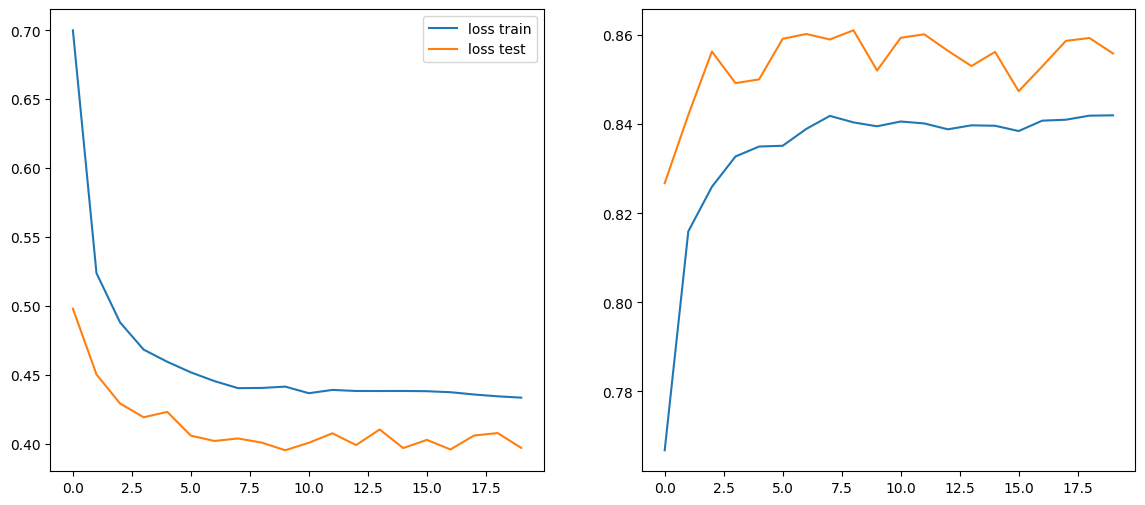

In [19]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
ax.plot(loss_list,label='loss train')
ax.plot(loss_list_test,label='loss test')
ax.legend()
ax = fig.add_subplot(122)
ax.plot(accuracy_list,label='accuracy train')
ax.plot(accuracy_list_test,label='accuracy test')


In [20]:
table = pd.crosstab(true_test,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(true_test, y_pred))

Predicted    0    1    2    3    4
True                              
0          138   13    5    5    1
1           34  117    9    1    1
2            8    7  136    4    7
3            6    3   11  142    0
4            3    1    1    0  157
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       162
           1       0.83      0.72      0.77       162
           2       0.84      0.84      0.84       162
           3       0.93      0.88      0.90       162
           4       0.95      0.97      0.96       162

    accuracy                           0.85       810
   macro avg       0.86      0.85      0.85       810
weighted avg       0.86      0.85      0.85       810



In [72]:
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')
print(X_test.shape)

test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))
test_loader = DataLoader(test_set, batch_size=200)


(21892, 187)


## base de TEST

In [119]:
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')
print(X_test.shape)

(21892, 187)


In [120]:

test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))
test_loader = DataLoader(test_set, batch_size=200)

In [74]:
model = joblib.load('../models/tl_v2_eff_13.pkl')
criterion = nn.CrossEntropyLoss()


In [106]:
def evaluate_model(model, test_loader):
    progress_bar = tqdm(
            test_loader, desc="test full", leave=True, disable=False
        )
    device="cpu"
    loss_test=0
    y_pred = []
    y_true = []
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    for batch in progress_bar:
        # Batch de données
        X_val, y_val = batch
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        #for X_val, y_val in test_loader:
        X_val = sig2cwtimage_tensor(X_val)
        X_val = X_val.unsqueeze(1).expand([-1,3,-1,-1])
        X_val = X_val.to(device)
        with torch.no_grad():
             pred = model(X_val.to(torch.float32))
        loss = criterion(pred, y_val)
        loss_test += loss.item()
        pred = np.argmax(pred.detach().numpy(),axis=1)

      
        y_pred += list(pred)
        y_true += list(y_val.detach().numpy())
        loss_test += loss.item()
        #print(np.array(y_true).shape,np.array(y_pred).shape)
    loss_test = loss_test/len(test_loader)
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test
    

In [107]:
y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,test_loader)


test full:   0%|          | 0/110 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


              precision    recall  f1-score   support

           0      0.982     0.873     0.924     18118
           1      0.277     0.707     0.398       556
           2      0.726     0.811     0.766      1448
           3      0.156     0.920     0.266       162
           4      0.865     0.959     0.910      1608

    accuracy                          0.872     21892
   macro avg      0.601     0.854     0.653     21892
weighted avg      0.932     0.872     0.895     21892



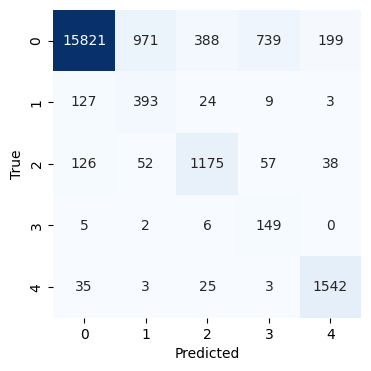

In [111]:
print(classification_report(y_true, y_pred,digits=3))
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')

In [114]:
summary(model);

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       (864)
|    |    └─BatchNorm2d: 3-2                  (64)
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─MBConv: 3-4                       (1,448)
|    └─Sequential: 2-3                        --
|    |    └─MBConv: 3-5                       (6,004)
|    |    └─MBConv: 3-6                       (10,710)
|    └─Sequential: 2-4                        --
|    |    └─MBConv: 3-7                       (15,350)
|    |    └─MBConv: 3-8                       (31,290)
|    └─Sequential: 2-5                        --
|    |    └─MBConv: 3-9                       (37,130)
|    |    └─MBConv: 3-10                      (102,900)
|    |    └─MBConv: 3-11                      (102,900)
|    └─Sequential: 2-6                        --
|    |    └

## Modele optimisé sur la base 13000

In [121]:
model = joblib.load('../models/tl_eff_9.pkl')


In [122]:
y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,test_loader)


test full:   0%|          | 0/110 [00:00<?, ?it/s]

C:\Users\passage\AppData\Local\Temp\ipykernel_5548\3063795176.py:10: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  Y[k,:,:] = np.sqrt(abs(cwt(X[k,:],morlet2,widths))/cwtNorm)


              precision    recall  f1-score   support

           0      0.985     0.842     0.908     18118
           1      0.252     0.728     0.374       556
           2      0.657     0.834     0.735      1448
           3      0.129     0.914     0.225       162
           4      0.850     0.957     0.901      1608

    accuracy                          0.848     21892
   macro avg      0.575     0.855     0.629     21892
weighted avg      0.929     0.848     0.877     21892



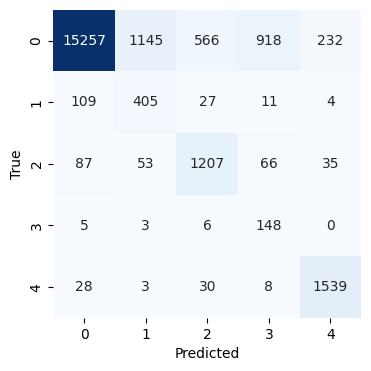

In [124]:
print(classification_report(y_true, y_pred,digits=3))
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')

In [117]:
summary(model);

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       (864)
|    |    └─BatchNorm2d: 3-2                  (64)
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─MBConv: 3-4                       (1,448)
|    └─Sequential: 2-3                        --
|    |    └─MBConv: 3-5                       (6,004)
|    |    └─MBConv: 3-6                       (10,710)
|    └─Sequential: 2-4                        --
|    |    └─MBConv: 3-7                       (15,350)
|    |    └─MBConv: 3-8                       (31,290)
|    └─Sequential: 2-5                        --
|    |    └─MBConv: 3-9                       (37,130)
|    |    └─MBConv: 3-10                      (102,900)
|    |    └─MBConv: 3-11                      (102,900)
|    └─Sequential: 2-6                        --
|    |    └